<a href="https://colab.research.google.com/github/zxhom26/SharkPaleobiologyResearch/blob/main/SharkPaleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shark Paleobiology Final Project

In [70]:
%pip install pyefd

In [71]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pyefd import elliptic_fourier_descriptors, normalize_efd, reconstruct_contour
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [72]:
from google.colab import userdata
token = userdata.get('shark_paleo_token')

In [73]:
%cd /content
!git config --global user.name "zxhom26"
!git config --global user.email "zxhom26@gmail.com"
!git clone https://github.com/zxhom26/SharkPaleobiologyResearch.git
!git remote set-url origin https://{token}@github.com/zxhom26/SharkPaleobiologyResearch.git
%cd /content/SharkPaleobiologyResearch

/content
fatal: destination path 'SharkPaleobiologyResearch' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
/content/SharkPaleobiologyResearch


## Process Images and Calculate EFDs
1. Load images from GitHub
2. Convert the images from RGB to binary BW silhouettes
3. Draw contours and select the max
4. Compute elliptical fourier descriptors from the contour
5. Store image, species, and efd data in a Pandas Dataframe

In [74]:
def extract_silhouette(raw_img):
  """
  Convert raw image to binary black and white image.

  Parameters:
  - raw_img: str, raw image file path

  Returns:
  - bw: numpy.ndarray, black and white binary image
  """
  # Read in image as grayscale
  gray = cv2.imread(raw_img, cv2.IMREAD_GRAYSCALE)
  if gray is None:
      print(f"Warning: could not read {raw_img}")
      return None

  # Threshold to binary (white tooth, black background REQUIRED FOR CONTOUR)
  _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return bw

In [75]:
def get_contour(bw, img_path):
  """
  Extract the largest contour from a given binary image.

  Parameters:
  - bw: numpy.ndarray, black and white binary image
  - img_path: str, raw image file path

  Returns:
  - contour: numpy.ndarray, max contour after removing redundant dimension
  """
  # Find largest outer contour
  contours, _ = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  if not contours:
      print(f"No contours found in {img_path}")
      return None

  contour = max(contours, key=cv2.contourArea) # gets largest contour
  contour = np.squeeze(contour) # remove unused dimension from findcontours

  if contour.ndim != 2 or contour.shape[1] != 2 or len(contour) < 5:
      print(f"Invalid contour in {img_path}, shape={contour.shape}")
      return None

  return contour

In [76]:
def compute_efd(folder, species_label, efd_order=15):
    """
    Load images from a folder, convert to binary, extract largest contour,
    compute normalized EFDs, and return a DataFrame.

    Parameters:
    - folder: str, path to image folder
    - species_label: str, species name to store in DataFrame
    - efd_order: int, number of harmonics for EFD

    Returns:
    - df: Pandas DataFrame with columns: ['image', 'path', 'efa_coeffs', 'species']
    - contour: Contour for the last tooth in the folder (to validate reconstruction)
    - efd: EFA descriptors for the last tooth in the folder (to validate reconstruction)
    """
    records = []

    for img_path in glob.glob(os.path.join(folder, '*.JPG')):
        # Convert image to binary
        bw = extract_silhouette(img_path)
        if bw is None:
          print(f"Could not convert {img_path} to BINARY. Skipping...")
          continue

        # # Display raw/BW image side-by-side
        # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        # ax[0].imshow(cv2.imread(img_path), cmap='gray')
        # ax[0].set_title(f"RAW: {os.path.basename(img_path)}")
        # ax[0].axis("off")
        # ax[1].imshow(bw, cmap='gray')
        # ax[1].set_title("Binary Silhouette (BW)")
        # ax[1].axis("off")
        # plt.show()

        # Extract max contour from binary image
        contour = get_contour(bw, img_path)
        if contour is None:
          print(f"Could not get CONTOURS from {img_path}. Skipping...")
          continue

        # Compute EFD and normalize
        efd = elliptic_fourier_descriptors(contour, order=efd_order)
        norm_efd = normalize_efd(efd, size_invariant=True) # rotation, phase, and size invariant

        # Phase invariant aligns contour starting points to compare harmonics

        # Store single tooth record
        records.append({
            'image': bw,
            'path': img_path,
            'efa_coeffs': norm_efd,
            'species': species_label
        })

    df = pd.DataFrame(records)
    return df, contour, efd


### Run Elliptical Fourier Analysis

In [77]:
df_bull, bull_contour, last_bull_efd = compute_efd('/content/SharkPaleobiologyResearch/Bull/','Bull')
df_java, java_contour, last_java_efd = compute_efd('/content/SharkPaleobiologyResearch/Java/','Java')


### Contour Reconstruction to Validate EFD
Reconstructing the last contour processed to confirm our shape data is correctly calibrated

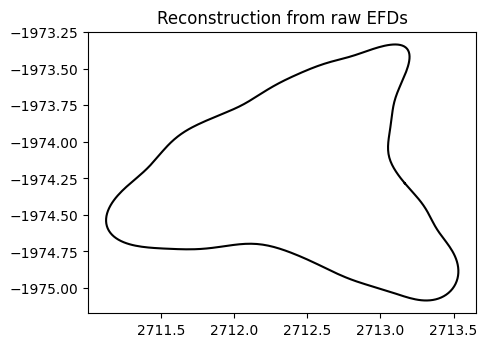

In [78]:
# Reconstruct contour test
A0 = bull_contour[:,0].mean()   # mean x
C0 = bull_contour[:,1].mean()   # mean y
recon = reconstruct_contour(last_bull_efd, locus=(A0, C0), num_points=400)
x, y = recon[:,0], recon[:,1]
plt.figure(figsize=(5,6))
plt.plot(x, -y, '-k')                          # invert y to match cv2 visual coords
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstruction from raw EFDs')
plt.show()

## Principal Component Analysis (PCA)
Linear dimension reduction technique

### Run PCA

In [79]:
def pca_decomposition(df, n_components=1):
    # Flatten each EFD coefficient matrix into a row vector
    X = np.array([c.flatten() for c in df['efa_coeffs']])

    pca = PCA(n_components=n_components)
    pca_scores = pca.fit_transform(X)

    df['pca'] = pca_scores[:, 0]

    return df, pca_scores

In [80]:
pca_bull, pca_scores_bull = pca_decomposition(df_bull)
pca_java, pca_scores_java = pca_decomposition(df_java)
pca_teeth = pd.concat([df_bull, df_java])
pca_scores = np.concatenate((pca_scores_bull, pca_scores_java), axis=0)

### Plot PCA Groupings

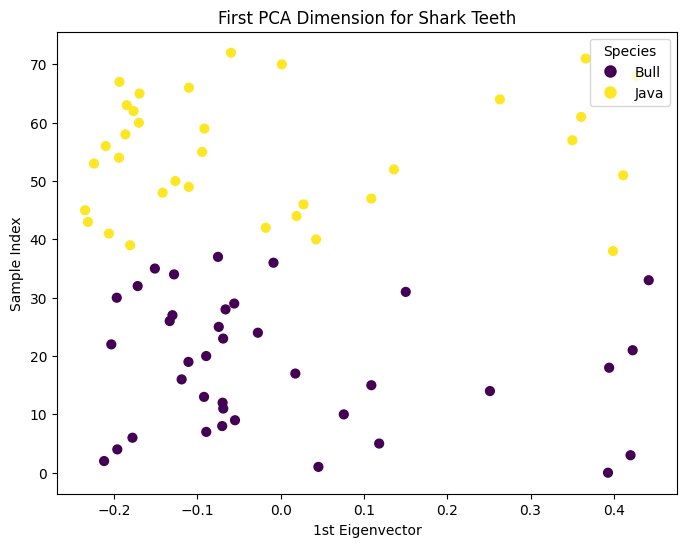

In [81]:
fig = plt.figure(1, figsize=(8, 6))
# Changed to 2D subplot as X_reduced is 1D
ax = fig.add_subplot(111)

X_reduced = pca_teeth['pca'] # This is a pandas Series

# Encode species for coloring
unique_species = pca_teeth['species'].unique()
species_colors = {species: i for i, species in enumerate(unique_species)}
c_values = pca_teeth['species'].map(species_colors)

# Get a colormap for the legend
num_species = len(unique_species)
# Updated to use the recommended way to get a colormap
colormap = plt.get_cmap('viridis', num_species)

scatter = ax.scatter(
    X_reduced, # Correctly use the 1D Series
    np.arange(len(X_reduced)), # Use sample index for the Y-axis to visualize individual points
    c=c_values, # Use encoded species for coloring
    cmap=colormap, # Specify the colormap
    s=40,
)

ax.set(
    title="First PCA Dimension for Shark Teeth",
    xlabel="1st Eigenvector",
    ylabel="Sample Index",
)
# Removed set_ticklabels for x and y as they are now meaningful
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# ax.zaxis.set_ticklabels([]) # Removed for 2D plot

# Add a legend based on species
legend_handles = []
for species, color_val in species_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=species,
                                 markerfacecolor=colormap(color_val / (num_species - 1) if num_species > 1 else 0.5),
                                 markersize=10))

ax.legend(handles=legend_handles, loc="upper right", title="Species")

plt.show()

## T-Distributed Stochastic Neighbor Embedding (t-SNE)
Non-linear dimension reduction technique

### Run t-SNE

In [82]:
def tsne_decomposition(df, n_components=1):
    # Flatten each EFD coefficient matrix into a row vector
    X = np.array([c.flatten() for c in df['efa_coeffs']])

    # Perplexity should be lower than num samples
    tsne = TSNE(n_components=n_components, perplexity=20, init='random', random_state=42)
    tsne_scores = tsne.fit_transform(X)

    df['tsne'] = tsne_scores[:, 0]

    return df, tsne_scores

In [83]:
tsne_bull, tsne_scores_bull = tsne_decomposition(pca_bull)
tsne_java, tsne_scores_java = tsne_decomposition(pca_java)

tsne_teeth = pd.concat([tsne_bull, tsne_java])
tsne_scores = np.concatenate((tsne_scores_bull, tsne_scores_java), axis=0)

### Plot t-SNE Groupings

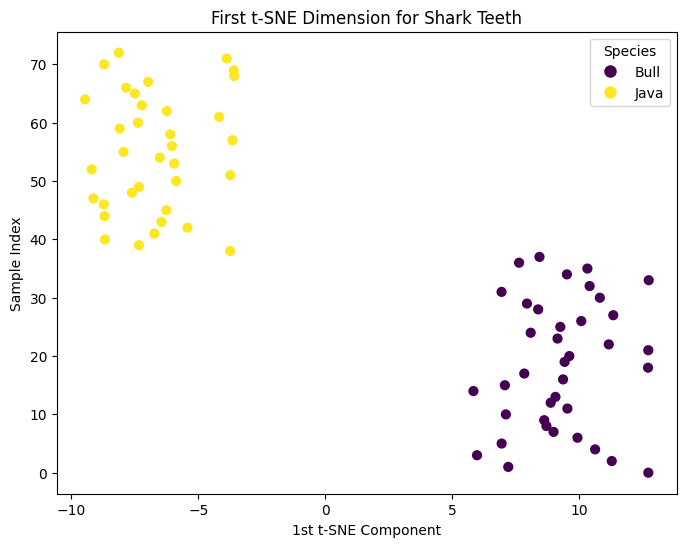

In [84]:
X_embedded = tsne_teeth['tsne']

# Visualize the results for 1D t-SNE, similar to PCA plot
fig, ax = plt.subplots(figsize=(8, 6))

# Encode species for coloring
unique_species = tsne_teeth['species'].unique()
species_colors = {species: i for i, species in enumerate(unique_species)}
c_values = tsne_teeth['species'].map(species_colors)

# Get a colormap for the legend
num_species = len(unique_species)
colormap = plt.get_cmap('viridis', num_species)

scatter = ax.scatter(
    X_embedded, # Use the 1D t-SNE scores directly for the x-axis
    np.arange(len(X_embedded)), # Use sample index for the Y-axis
    c=c_values, # Use encoded species for coloring
    cmap=colormap, # Specify the colormap
    s=40,
)

ax.set(
    title="First t-SNE Dimension for Shark Teeth",
    xlabel="1st t-SNE Component",
    ylabel="Sample Index",
)

# Add a legend based on species
legend_handles = []
for species, color_val in species_colors.items():
    # Adjusted markerfacecolor calculation for colormap
    color_normalized = color_val / (num_species - 1) if num_species > 1 else 0.5
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=species,
                                 markerfacecolor=colormap(color_normalized),
                                 markersize=10))

ax.legend(handles=legend_handles, loc="upper right", title="Species")

plt.show()

## Comparing Dimension Reduction Algorithms

### Silhouette Score

In [85]:
species_labels = tsne_teeth['species'].values

sil_pca = silhouette_score(pca_scores, species_labels)
sil_tsne = silhouette_score(tsne_scores, species_labels)

print("Silhouette PCA:", sil_pca)
print("Silhouette t-SNE:", sil_tsne)

Silhouette PCA: 0.011220531861740553
Silhouette t-SNE: 0.86650854


DEAD CODE

In [86]:
# @title
# def compute_efd(folder, species_label, efd_order=15):
#     """
#     Load images from a folder, convert to binary, extract largest contour,
#     compute normalized EFDs, and return a DataFrame.

#     Parameters:
#     - folder: str, path to image folder
#     - species_label: str, species name to store in DataFrame
#     - efd_order: int, number of harmonics for EFD

#     Returns:
#     - df: Pandas DataFrame with columns: ['image', 'path', 'efa_coeffs', 'species']
#     """
#     records = []

#     for img_path in glob.glob(os.path.join(folder, '*.JPG')):
#         # # Read grayscale
#         # gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         # if gray is None:
#         #     print(f"Warning: could not read {img_path}")
#         #     continue

#         # # Threshold to binary (adaptive)
#         # _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         # # white tooth, black background!!! REQUIRED FOR CONTOUR

#         bw = extract_silhouette(img_path)
#         if bw is None:
#           print(f"Could not convert {img_path} to BINARY. Skipping...")
#           continue

#         # # Find largest outer contour
#         # contours, _ = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#         # if not contours:
#         #     print(f"No contours found in {img_path}")
#         #     continue
#         # contour = max(contours, key=cv2.contourArea) # gets largest contour
#         # contour = np.squeeze(contour)

#         # if contour.ndim != 2 or contour.shape[1] != 2 or len(contour) < 5:
#         #     print(f"Invalid contour in {img_path}, shape={contour.shape}")
#         #     continue
#         contour = get_contour(bw, img_path)
#         if contour is None:
#           print(f"Could not get CONTOURS from {img_path}. Skipping...")
#           continue

#         # Compute EFD and normalize
#         efd = elliptic_fourier_descriptors(contour, order=efd_order)
#         norm_efd = normalize_efd(efd, size_invariant=True)
#         # rotation and size invariant
#         # aligns contour starting point (phase invariant)

#         # Store record
#         records.append({
#             'image': bw,
#             'path': img_path,
#             'efa_coeffs': norm_efd,
#             'species': species_label
#         })

#     df = pd.DataFrame(records)
#     return df, contour, efd